In [1]:
# import libraries
from cil.optimisation.functions import TotalVariation, OperatorCompositionFunction, L2NormSquared, SmoothMixedL21Norm
from cil.framework import ImageGeometry
from cil.optimisation.operators import GradientOperator
from cil.optimisation.algorithms import GD, FISTA
from cil.utilities.dataexample import TestData
from cil.utilities.display import plotter2D

from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim

import matplotlib.pyplot as plt
import numpy as np

import os, sys

In [2]:
# Load an image from the CIL gallery. 
loader = TestData(data_dir=os.path.join(sys.prefix, 'share','cil'))
data = loader.load(TestData.SIMPLE_PHANTOM_2D)
ig = data.geometry  
    
# Add gaussian noise
noisy_data = TestData.random_noise(data, mode = 'gaussian', seed = 10, var = 0.005) 

In [3]:
# TV regularisation parameter
alpha = 3

# Smooth regularisation parameter
epsilon = 1e-6

In [4]:
# Smooth TV functional
Grad = GradientOperator(ig)
f1 = OperatorCompositionFunction( alpha * SmoothMixedL21Norm(epsilon), Grad)

# fidelity
f2 = 0.5 * L2NormSquared(b=noisy_data)

# Sum two smooth functionals together
objective_function = f1  +  f2

# Set algorithm parameters
step_size = 0.00002
x_init = noisy_data

# Set up and run Gradient Descent algorithm
print("Running Gradient Descent with smooth approximation of TV.\nThis will take some time .... ")
gd = GD(x_init, objective_function, step_size=step_size,
                     max_iteration = 10000,update_objective_interval = 1000)
gd.run(verbose=True)

Initialised GradientOperator with C backend running with  20  threads
Running Gradient Descent with smooth approximation of TV.
This will take some time .... 
GD setting up
GD configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0      10000         0.000          5.90830e+04
     1000      10000         0.009          4.04300e+03
     2000      10000         0.009          3.65109e+03
     3000      10000         0.009          3.62666e+03
     4000      10000         0.009          3.61249e+03
     5000      10000         0.009          3.60110e+03
     6000      10000         0.009          3.59051e+03
     7000      10000         0.009          3.58193e+03
     8000      10000         0.009          3.57130e+03
     9000      10000         0.009          3.56479e+03
    10000      10000         0.009          3.55950e+03
-------------------------------------------------------
    10000      10000         

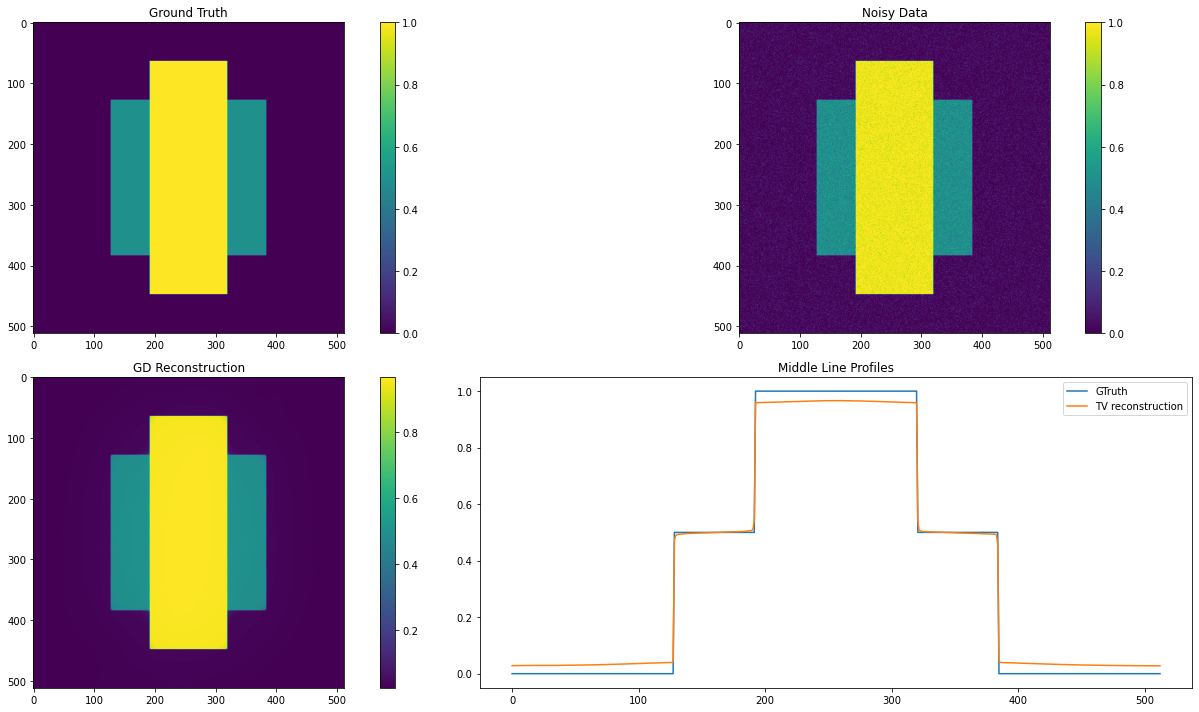

In [7]:
## Show Gradient Descent reconstruction results
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(data.as_array())
plt.title('Ground Truth')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(noisy_data.as_array())
plt.title('Noisy Data')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(gd.get_output().as_array())
plt.title('GD Reconstruction')
plt.colorbar()
plt.subplot(2,2,4)
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), data.as_array()[int(ig.shape[0]/2),:], label = 'GTruth')
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), gd.get_output().as_array()[int(ig.shape[0]/2),:], label = 'TV reconstruction')
plt.legend()
plt.title('Middle Line Profiles')
plt.tight_layout()
plt.show()

In [9]:
objective_function.L

24.500322341918945

In [11]:
#  Use FISTA algorithm to solve same smoothed TV regularised denoising proglem

# Manually set guess of Lipschitz parameter of function to step size selection.
objective_function.L = 1000000

# Set up and run FISTA algorithms
print("Running FISTA with smooth approximation of TV.\nThis will take some time .... ")
fi = FISTA(initial = ig.allocate(), f = objective_function, max_iteration = 10000, 
           update_objective_interval = 1000)
fi.run(verbose=True)


objective_function.L = 1000000

# Set up and run FISTA algorithms
print("Running FISTA with smooth approximation of TV.\nThis will take some time .... ")
fi = FISTA(x_init, objective_function, max_iteration = 10000, 
           update_objective_interval = 100)
fi.run(verbose=True)

Running FISTA with smooth approximation of TV.
This will take some time .... 
FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0      10000         0.000          2.76432e+04
     1000      10000         0.007          1.59286e+05
     2000      10000         0.007          1.59183e+05
     3000      10000         0.007          1.59144e+05
     4000      10000         0.007          1.59130e+05
     5000      10000         0.007          1.59115e+05
     6000      10000         0.007          1.59106e+05
     7000      10000         0.007          1.59102e+05
     8000      10000         0.007          1.59099e+05
     9000      10000         0.007          1.59091e+05
    10000      10000         0.007          1.59091e+05
-------------------------------------------------------
    10000      10000         0.007          1.59091e+05
Stop criterion has been reached.



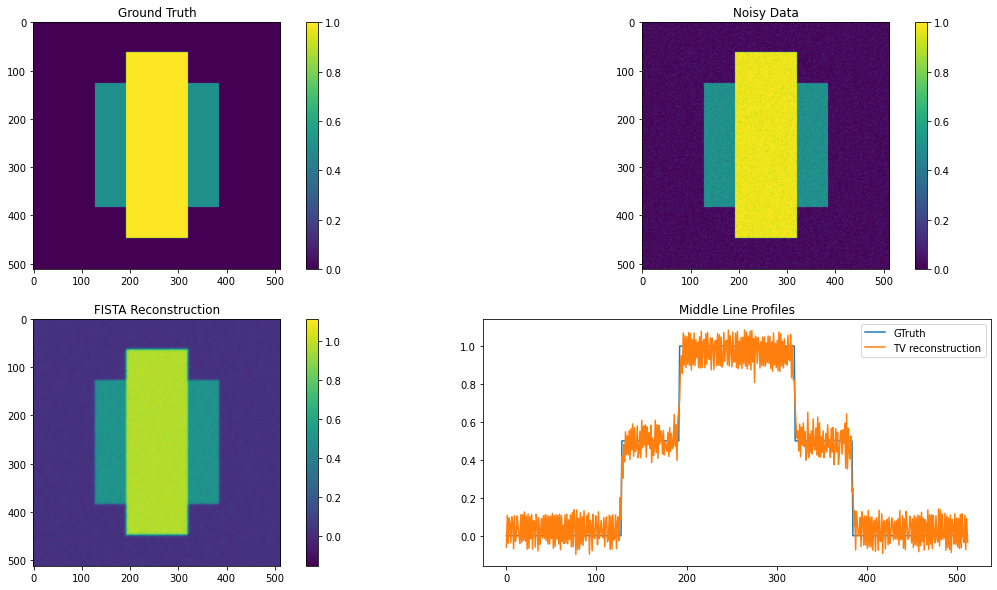

In [79]:
## Show FISTA reconstruction results
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(data.as_array())
plt.title('Ground Truth')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(noisy_data.as_array())
plt.title('Noisy Data')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(fista.get_output().as_array())
plt.title('FISTA Reconstruction')
plt.colorbar()
plt.subplot(2,2,4)
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), data.as_array()[int(ig.shape[0]/2),:], label = 'GTruth')
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), fista.get_output().as_array()[int(ig.shape[0]/2),:], label = 'TV reconstruction')
plt.legend()
plt.title('Middle Line Profiles')
plt.show()

In [66]:
#%% Use PDHG to solve non-smooth version of problem for comparison

# Set up non-smooth TV regularisation term
operator = Grad
f =  alpha * MixedL21Norm()
        
# Set algorithm parameters: primal and dual step sizes, sigma and tau, 
# standard choices based on operator's norm.
normK = operator.norm()
sigma = 1
tau = 1/(sigma*normK**2)

# Setup and run the PDHG algorithm
print("Running PDHG with non-smooth TV.\nThis will take some time...")
pdhg = PDHG(f=f,g=f2,operator=operator, tau=tau, sigma=sigma)
pdhg.max_iteration = 10000
pdhg.update_objective_interval = 100
pdhg.run(very_verbose=True)

## Show PDHG reconstruction results
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(data.as_array())
plt.title('Ground Truth')
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(noisy_data.as_array())
plt.title('Noisy Data')
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(pdhg.get_output().as_array())
plt.title('PDHG Reconstruction')
plt.colorbar()
plt.subplot(1,4,4)
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), data.as_array()[int(ig.shape[0]/2),:], label = 'GTruth')
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), pdhg.get_output().as_array()[int(ig.shape[0]/2),:], label = 'TV reconstruction')
plt.legend()
plt.title('Middle Line Profiles')
plt.show()

#%%

# Plot convergence of GD, FISTA and for PDHG both primal, dual objectives 
# and the duality gap. The primal and dual  objective should converge to 
# each other and the gap, which is the difference between the two, should
# approach zero, which it can be seen to do.
plt.figure()
plt.loglog(gd.objective,label = 'GD')
plt.loglog(fi.objective,label = 'FISTA')
plt.loglog(pdhg.objective,label = 'PDHG primal')
plt.loglog(pdhg.dual_objective,label = 'PDHG dual')
plt.loglog(pdhg.primal_dual_gap,label = 'PDHG gap')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('objective')
plt.show()
# © 2021 GitHu

NameError: name 'MixedL21Norm' is not defined

Initialised GradientOperator with C backend running with  20  threads
Running Gradient Descent with smooth approximation of TV.
This will take some time .... 
GD setting up
GD configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0      10000         0.000          8.21473e+04
-------------------------------------------------------
        2      10000         0.009                     
Stop criterion has been reached.



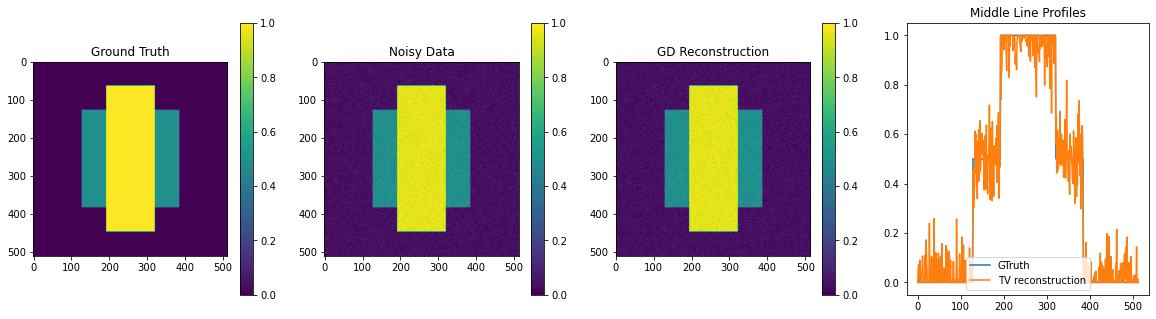

Running FISTA with smooth approximation of TV.
This will take some time .... 
FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0      10000         0.000          8.21473e+04
      100      10000         0.007          2.06248e+05
      200      10000         0.007          2.04093e+05
      300      10000         0.007          2.03269e+05
      400      10000         0.007          2.02898e+05
      500      10000         0.007          2.02702e+05
      600      10000         0.007          2.02582e+05


In [ ]:
#%% Load test image and add noise
loader = TestData(data_dir=os.path.join(sys.prefix, 'share','ccpi'))
data = loader.load(TestData.SIMPLE_PHANTOM_2D, size=(512,512))
ig = data.geometry
ag = ig

n1 = TestData.random_noise(data.as_array(), mode = 'gaussian', seed = 10)

noisy_data = ig.allocate()
noisy_data.fill(n1)

#%% Set up least squares plus smoothed TV regularisation denoising problem 
#   and solve with Gradient Descent with constant step size.

# TV regularisation and smoothing parameters
alpha = 3
epsilon = 1e-6

# Smooth TV functional
Grad = GradientOperator(ig)
f1 = OperatorCompositionFunction( alpha * SmoothMixedL21Norm(epsilon), Grad)

# Least squares denoising functional (no forward operator)
f2 = 0.5 * L2NormSquared(b=noisy_data)

# Sum two smooth functionals together
objective_function = f1  +  f2

# Set algorithm parameters
step_size = 0.00002
x_init = noisy_data

# Set up and run Gradient Descent algorithm
print("Running Gradient Descent with smooth approximation of TV.\nThis will take some time .... ")
gd = GD(x_init, objective_function, step_size=step_size,
                     max_iteration = 10000,update_objective_interval = 1000)
gd.run(2,verbose=True)

## Show Gradient Descent reconstruction results
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(data.as_array())
plt.title('Ground Truth')
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(noisy_data.as_array())
plt.title('Noisy Data')
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(gd.get_output().as_array())
plt.title('GD Reconstruction')
plt.colorbar()
plt.subplot(1,4,4)
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), data.as_array()[int(ig.shape[0]/2),:], label = 'GTruth')
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), gd.get_output().as_array()[int(ig.shape[0]/2),:], label = 'TV reconstruction')
plt.legend()
plt.title('Middle Line Profiles')
plt.show()


#%%  Use FISTA algorithm to solve same smoothed TV regularised denoising proglem

# Manually set guess of Lipschitz parameter of function to step size selection.
objective_function.L = 10

# Set up and run FISTA algorithms
print("Running FISTA with smooth approximation of TV.\nThis will take some time .... ")
fi = FISTA(x_init, objective_function, max_iteration = 10000, 
           update_objective_interval = 100)
fi.run(verbose=True)

## Show FISTA reconstruction results
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(data.as_array())
plt.title('Ground Truth')
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(noisy_data.as_array())
plt.title('Noisy Data')
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(fi.get_output().as_array())
plt.title('FISTA Reconstruction')
plt.colorbar()
plt.subplot(1,4,4)
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), data.as_array()[int(ig.shape[0]/2),:], label = 'GTruth')
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), fi.get_output().as_array()[int(ig.shape[0]/2),:], label = 'TV reconstruction')
plt.legend()
plt.title('Middle Line Profiles')
plt.show()


#%% Use PDHG to solve non-smooth version of problem for comparison

# Set up non-smooth TV regularisation term
operator = Grad
f =  alpha * MixedL21Norm()
        
# Set algorithm parameters: primal and dual step sizes, sigma and tau, 
# standard choices based on operator's norm.
normK = operator.norm()
sigma = 1
tau = 1/(sigma*normK**2)

# Setup and run the PDHG algorithm
print("Running PDHG with non-smooth TV.\nThis will take some time...")
pdhg = PDHG(f=f,g=f2,operator=operator, tau=tau, sigma=sigma)
pdhg.max_iteration = 10000
pdhg.update_objective_interval = 100
pdhg.run(very_verbose=True)

## Show PDHG reconstruction results
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(data.as_array())
plt.title('Ground Truth')
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(noisy_data.as_array())
plt.title('Noisy Data')
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(pdhg.get_output().as_array())
plt.title('PDHG Reconstruction')
plt.colorbar()
plt.subplot(1,4,4)
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), data.as_array()[int(ig.shape[0]/2),:], label = 'GTruth')
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), pdhg.get_output().as_array()[int(ig.shape[0]/2),:], label = 'TV reconstruction')
plt.legend()
plt.title('Middle Line Profiles')
plt.show()

#%%

# Plot convergence of GD, FISTA and for PDHG both primal, dual objectives 
# and the duality gap. The primal and dual  objective should converge to 
# each other and the gap, which is the difference between the two, should
# approach zero, which it can be seen to do.
plt.figure()
plt.loglog(gd.objective,label = 'GD')
plt.loglog(fi.objective,label = 'FISTA')
plt.loglog(pdhg.objective,label = 'PDHG primal')
plt.loglog(pdhg.dual_objective,label = 'PDHG dual')
plt.loglog(pdhg.primal_dual_gap,label = 'PDHG gap')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('objective')
plt.show()
